In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta,date


In [60]:
df = pd.read_csv('OnlineRetail.csv', encoding='unicode_escape')

In [61]:
df.shape

(541909, 8)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [63]:
df["InvoiceDate"] = pd.to_datetime(df['InvoiceDate'])

In [64]:
df[['Date', 'Time']] = pd.DataFrame({'Date': df['InvoiceDate'].dt.date, 'Time': df['InvoiceDate'].dt.time})

In [65]:
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00


In [66]:
df_uk = df.query("Country=='United Kingdom'").reset_index(drop=True)

In [67]:
df_uk

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
...,...,...,...,...,...,...,...,...,...,...
495473,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom,2011-12-09,12:31:00
495474,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,2011-12-09,12:49:00
495475,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom,2011-12-09,12:49:00
495476,581586,21217,RED RETROSPOT ROUND CAKE TINS,24,2011-12-09 12:49:00,8.95,13113.0,United Kingdom,2011-12-09,12:49:00


- Define an appropriate time frame for Customer Lifetime Value calculation
- Identify the features we are going to use to predict future and create them
- Calculate lifetime value (LTV) for training the machine learning model
- Build and run the machine learning model
- Check if the model is useful

# Calculate RFM for 3 months

In [68]:
df_uk.Date.max()

datetime.date(2011, 12, 9)

In [69]:
df_uk.Date.min()

datetime.date(2010, 12, 1)

In [70]:

# Define the time ranges using integers and datetime objects
start_3m = datetime(2011, 3, 1)
end_3m = start_3m + timedelta(days=3*30)  # Assuming 30 days in a month
start_6m = datetime(2011, 6, 1)
end_6m = start_6m + timedelta(days=6*30)

# Filter the DataFrame based on the time ranges
df_3m = df_uk[(df_uk.InvoiceDate < end_3m) & (df_uk.InvoiceDate >= start_3m)].reset_index(drop=True)
df_6m = df_uk[(df_uk.InvoiceDate >= start_6m) & (df_uk.InvoiceDate < end_6m)].reset_index(drop=True)


In [71]:
df_user = pd.DataFrame(df_3m["CustomerID"].unique())

In [72]:
df_user.columns = ["CustomerID"]

In [73]:
df_user.head()

,CustomerID
0,14620.0
1,14740.0
2,13880.0
3,16462.0
4,17068.0


# Recency

In [74]:
# creating a general user dataframe to append RFM scores
df_user = pd.DataFrame(df_3m["CustomerID"].unique(), columns=["CustomerID"])

In [75]:
#df_user.info()
# Group all the customer IDs with the most recent purchase
df3_maxPurchase = df_3m.groupby("CustomerID")["Date"].max().reset_index()

In [76]:
#df3_maxPurchase.info()
# rename column names
df3_maxPurchase.columns = ["CustomerID", "MaxPurchaseDate"]

In [77]:
# Set the observation point as the maximum invoice date in the dataset
max_invoice_date = df3_maxPurchase['MaxPurchaseDate'].max()
df3_maxPurchase['Recency'] = (max_invoice_date - df3_maxPurchase['MaxPurchaseDate']).dt.days

In [78]:
#df3_maxPurchase.head()
# merge the recency dataframe with the user dataframedf
df_user = pd.merge(df_user, df3_maxPurchase[['CustomerID', 'Recency']], on='CustomerID')
#df_user = df_user.drop('Recency_y', axis=1)


In [79]:
df_user

,CustomerID,Recency
0,14620.0,10
1,14740.0,3
2,13880.0,23
3,16462.0,89
4,17068.0,10
...,...,...
1824,14823.0,0
1825,15897.0,0
1826,16567.0,0
1827,17051.0,0


In [80]:
from sklearn.cluster import KMeans

In [81]:
kmeans = KMeans(n_clusters = 4).fit(df_user[["Recency"]])
df_user["RecencyScore"] = kmeans.predict(df_user[["Recency"]])

D:\Data_Analysis\Data-analysis-learning\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [82]:
df_user.head()

,CustomerID,Recency,RecencyScore
0,14620.0,10,2
1,14740.0,3,2
2,13880.0,23,0
3,16462.0,89,3
4,17068.0,10,2


# Frequency

In [83]:
df_frequency = df_3m.groupby("CustomerID").Date.count().reset_index()

In [84]:
df_frequency.columns = ["CustomerID","Frequency"]

In [85]:
df_user = pd.merge(df_user,
                    df_frequency, 
                    on = "CustomerID")

In [86]:
df_user.head()

,CustomerID,Recency,RecencyScore,Frequency
0,14620.0,10,2,30
1,14740.0,3,2,89
2,13880.0,23,0,38
3,16462.0,89,3,1
4,17068.0,10,2,76


In [87]:
kmeans = KMeans(n_clusters = 4).fit(df_user[["Frequency"]])
df_user["FrequencyScore"] = kmeans.predict(df_user[["Frequency"]])

D:\Data_Analysis\Data-analysis-learning\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [88]:
df_user.head()

,CustomerID,Recency,RecencyScore,Frequency,FrequencyScore
0,14620.0,10,2,30,0
1,14740.0,3,2,89,2
2,13880.0,23,0,38,0
3,16462.0,89,3,1,0
4,17068.0,10,2,76,2


# Revenue

In [89]:
df_3m["Revenue"] = df_3m["UnitPrice"]*df_3m["Quantity"]

In [90]:
df_3m.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,Revenue
0,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,2011-03-01 08:30:00,7.95,14620.0,United Kingdom,2011-03-01,08:30:00,15.9
1,545220,48194,DOORMAT HEARTS,2,2011-03-01 08:30:00,7.95,14620.0,United Kingdom,2011-03-01,08:30:00,15.9


In [91]:
df3_revenue = df_3m.groupby("CustomerID").Revenue.sum().reset_index()

In [92]:
df3_revenue.columns = ["CustomerID","TotalRevenue"]

In [93]:
df_user = pd.merge(df_user, df3_revenue, on="CustomerID")

In [94]:
df_user.head()

,CustomerID,Recency,RecencyScore,Frequency,FrequencyScore,TotalRevenue
0,14620.0,10,2,30,0,393.28
1,14740.0,3,2,89,2,1448.21
2,13880.0,23,0,38,0,718.63
3,16462.0,89,3,1,0,34.00
4,17068.0,10,2,76,2,1480.95


In [95]:
kmeans = KMeans(n_clusters = 4).fit(df_user[["TotalRevenue"]])
df_user['RevenueScore'] = kmeans.predict(df_user[["TotalRevenue"]])

D:\Data_Analysis\Data-analysis-learning\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [96]:
df_user.head()

,CustomerID,Recency,RecencyScore,Frequency,FrequencyScore,TotalRevenue,RevenueScore
0,14620.0,10,2,30,0,393.28,0
1,14740.0,3,2,89,2,1448.21,0
2,13880.0,23,0,38,0,718.63,0
3,16462.0,89,3,1,0,34.00,0
4,17068.0,10,2,76,2,1480.95,0


In [97]:
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    # Create a new cluster field name
    new_cluster_field_name = 'new_' + cluster_field_name
    
    # Group the DataFrame by the cluster field name and calculate the mean of the target field
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    # Sort the DataFrame by the target field in ascending or descending order
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    
    # Assign a new index based on the sorted order
    df_new['index'] = df_new.index
    
    # Merge the original DataFrame with the sorted DataFrame based on the cluster field name
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    
    # Remove the original cluster field name from the final DataFrame
    df_final = df_final.drop([cluster_field_name], axis=1)
    
    # Rename the index column as the cluster field name
    df_final = df_final.rename(columns={"index": cluster_field_name})
    
    # Return the final DataFrame with the ordered cluster field
    return df_final

In [98]:
df_user = order_cluster('RevenueScore', 'TotalRevenue',df_user,True)

In [99]:
df_user.head()

,CustomerID,Recency,RecencyScore,Frequency,FrequencyScore,TotalRevenue,RevenueScore
0,14620.0,10,2,30,0,393.28,0
1,14740.0,3,2,89,2,1448.21,0
2,13880.0,23,0,38,0,718.63,0
3,16462.0,89,3,1,0,34.00,0
4,17068.0,10,2,76,2,1480.95,0


In [100]:
df_user = order_cluster('FrequencyScore', 'Frequency',df_user,True)


In [101]:
df_user = order_cluster('RecencyScore', 'Recency', df_user, False)


In [102]:
df_user.head()

,CustomerID,Recency,Frequency,TotalRevenue,RevenueScore,FrequencyScore,RecencyScore
0,14620.0,10,30,393.28,0,0,3
1,15194.0,4,64,1439.02,0,0,3
2,18044.0,4,57,808.96,0,0,3
3,18075.0,10,35,638.12,0,0,3
4,15241.0,3,43,579.45,0,0,3


In [103]:
#overall scoring
df_user['OverallScore'] = df_user['RecencyScore'] + df_user['FrequencyScore'] + df_user['RevenueScore']
df_user['Segment'] = 'Low-Value'
df_user.loc[df_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
df_user.loc[df_user['OverallScore']>4,'Segment'] = 'High-Value'

In [105]:
df_user.sample(15)

,CustomerID,Recency,Frequency,TotalRevenue,RevenueScore,FrequencyScore,RecencyScore,OverallScore,Segment
83,13650.0,11,38,718.52,0,0,3,3,Mid-Value
583,15092.0,21,26,457.81,0,0,2,2,Low-Value
435,16672.0,10,61,3462.24,1,0,3,4,Mid-Value
1255,17795.0,70,17,163.25,0,0,0,0,Low-Value
915,13242.0,19,5,104.00,0,0,2,2,Low-Value
471,14112.0,9,79,1069.50,0,1,3,4,Mid-Value
1046,13497.0,88,10,194.55,0,0,0,0,Low-Value
190,15570.0,12,48,541.33,0,0,3,3,Mid-Value
346,16690.0,7,5,86.50,0,0,3,3,Mid-Value
617,16359.0,20,27,464.61,0,0,2,2,Low-Value


In [126]:
#calculate revenue and create a new dataframe for it
df_6m['Revenue'] = df_6m['UnitPrice'] * df_6m['Quantity']
df_user_6m = df_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
df_user_6m.columns = ['CustomerID','m6_Revenue']

In [127]:
df_user_6m

,CustomerID,m6_Revenue
0,12747.0,1666.11
1,12748.0,17648.86
2,12749.0,2323.04
3,12820.0,561.53
4,12822.0,918.98
...,...,...
3122,18278.0,173.90
3123,18281.0,80.82
3124,18282.0,98.76
3125,18283.0,1128.22


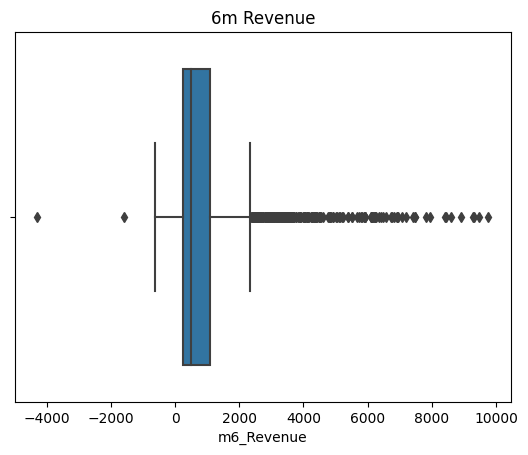

In [128]:
# Filter the data for LTV values less than 10000
filtered_data = df_user_6m.query('m6_Revenue < 10000')

# Plot the LTV histogram using Seaborn
sns.boxplot(x=filtered_data['m6_Revenue'])

# Set the title of the plot
plt.title('6m Revenue')

# Display the plot
plt.show()

In [129]:
df_merge = pd.merge(df_user, df_user_6m, on='CustomerID', how='left')
df_merge = df_merge.fillna(0)

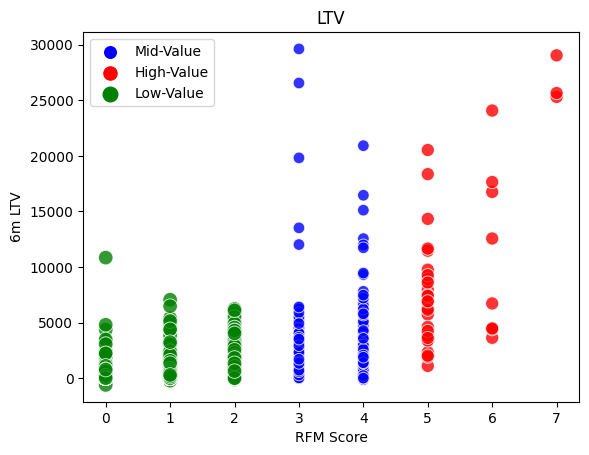

In [130]:
# Filter the data for LTV values less than 30000
filtered_data = df_merge.query("m6_Revenue < 30000")

# Create a scatter plot using Seaborn
sns.scatterplot(data=filtered_data, x='OverallScore', y='m6_Revenue', hue='Segment', palette=['blue', 'red', 'green'],
                size='Segment', sizes=[70, 90, 110], alpha=0.8)

# Set the title and axis labels of the plot
plt.title('LTV')
plt.xlabel('RFM Score')
plt.ylabel('6m LTV')

# Show the legend
plt.legend()

# Display the plot
plt.show()


In [131]:
#remove outliers
df_merge = df_merge[df_merge['m6_Revenue']<df_merge['m6_Revenue'].quantile(0.99)]


#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_merge[['m6_Revenue']])
df_merge['LTVCluster'] = kmeans.predict(df_merge[['m6_Revenue']])

#order cluster number based on LTV
df_merge = order_cluster('LTVCluster', 'm6_Revenue',df_merge,True)

#creatinga new cluster dataframe
df_cluster = df_merge.copy()

#see details of the clusters
df_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

D:\Data_Analysis\Data-analysis-learning\Python\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1394.0,394.565044,417.969771,-609.40,0.0000,291.415,677.8025,1437.89
1,364.0,2485.390027,936.617615,1445.31,1737.0250,2139.475,3036.7025,5196.98
2,52.0,8223.621346,2875.854089,5396.44,6140.7075,6911.615,9530.8225,16457.32


In [135]:
from sklearn.model_selection import train_test_split


In [136]:
#convert categorical columns to numerical
df_class = pd.get_dummies(df_cluster)

#calculate and show correlations
corr_matrix = df_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

#create X and y, X will be feature set and y is the label - LTV
X = df_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = df_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [137]:
df_cluster.head()

,CustomerID,Recency,Frequency,TotalRevenue,RevenueScore,FrequencyScore,RecencyScore,OverallScore,Segment,m6_Revenue,LTVCluster
0,14620.0,10,30,393.28,0,0,3,3,Mid-Value,0.00,0
1,18044.0,4,57,808.96,0,0,3,3,Mid-Value,991.54,0
2,18075.0,10,35,638.12,0,0,3,3,Mid-Value,1322.75,0
3,15241.0,3,43,579.45,0,0,3,3,Mid-Value,791.04,0
4,15660.0,2,34,484.62,0,0,3,3,Mid-Value,858.09,0


In [138]:
df_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1394.0,394.565044,417.969771,-609.40,0.0000,291.415,677.8025,1437.89
1,364.0,2485.390027,936.617615,1445.31,1737.0250,2139.475,3036.7025,5196.98
2,52.0,8223.621346,2875.854089,5396.44,6140.7075,6911.615,9530.8225,16457.32


In [140]:
df_class = pd.get_dummies(df_cluster)


In [141]:
corr_matrix = df_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.847195
TotalRevenue          0.609288
RevenueScore          0.472415
OverallScore          0.367388
FrequencyScore        0.364785
Frequency             0.359195
Segment_High-Value    0.334780
RecencyScore          0.229504
Segment_Mid-Value     0.164668
CustomerID           -0.028970
Recency              -0.229902
Segment_Low-Value    -0.256761
Name: LTVCluster, dtype: float64

In [142]:
X = df_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = df_class['LTVCluster']

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)


In [144]:
import xgboost as xgb

In [154]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.92
Accuracy of XGB classifier on test set: 0.77


In [155]:
df_class.groupby('LTVCluster').CustomerID.count()/df_class.CustomerID.count()


LTVCluster
0    0.770166
1    0.201105
2    0.028729
Name: CustomerID, dtype: float64

In [156]:
y_pred = ltv_xgb_model.predict(X_test)

In [157]:
from sklearn.metrics import classification_report,confusion_matrix

In [158]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        72
           1       0.29      0.27      0.28        15
           2       1.00      0.25      0.40         4

    accuracy                           0.77        91
   macro avg       0.71      0.47      0.52        91
weighted avg       0.77      0.77      0.76        91

